# Acerca del conjunto de datos

El conjunto de datos consta de Cienmil imagenes generadas de forma aleatoria con entre 5 y 15 piezas de tableros digitales de ajedrez.

Las imágenes fueron generadas usando 28 estilos de tableros de ajedrez y 32 estilos de piezas diferentes generando 896 combinaciones de estilo. 

Fueron generadas con este [generador de tableros digitales](https://github.com/koryakinp/chess-generator)

Las imagenes son originalmente de 400 x 400 pixeles. 

El conjunto de entrenamiento tiene 80000 imagenes y pruebas 20000 imagenes. 

Los datos pueden ser encontrados aquí: [Datos](https://www.kaggle.com/datasets/koryakinp/chess-positions)

La distribución de probabilidad es 

30% peón
20% alfil
20% Rey
20% Torre
10% Reina

El nombre del archivo fue etiquetado conforme a la notación Forsyth–Edwards Notation (FEN) que es una representación posicional de las piezas en el tablero:

![alt text](FEN_all_string.png)

![alt text](fen_one_rank.png)

# Descripción del problema

En la etapa de aprendizaje o profesionalización del ajedrez es común que los jugadores visualicen, a través de medios digitales como youtube, partidas de ajedrez de referentes mundiales como Magnus Carles y al encontrar partidas interesantes tengan la inquietud de analizar una posición determinada, para entender las ventajas y desventajas posicionales. De esta necesidad surge la idea de hacer un modelo que a partir de una imágen, encuentre su correspondiente cadena fen, que ya fue abordado, es una representación alfanumérica de todo el tablero. Esto puede alimentar otros modelos o herramientas web que ayuden al estudiante a entender las ideas detrás de movimientos realizados por maestros o cualquier aficionado de ajedrez que juegue a través de medios digitales. 

# Descripción de una propuesta de métricas que permitan evaluar el desempeño de tu modelo, justificando la selección de las métricas propuestas
El mejor modelo se seleccionó considerando principalmente el accuracy porque interesa maximizar el número de clases predichas de forma correcta y minimizar la diferencia entre las probabilidades pronosticadas y los resultados observados.
En este escenario la metrica es fiable porque al tener control sobre la generación de los datos se conoce el balance de las clases (detallado al principio del documento).

La métrica de *Accuracy* (exactitud) es ampliamente utilizada para evaluar la efectividad de modelos de clasificación en estadística y aprendizaje automático. Se define como la proporción de predicciones correctas (tanto positivas como negativas) entre el total de predicciones realizadas. Matemáticamente, se expresa como:

$$
\text{Accuracy} = \frac{\text{Número de Predicciones Correctas}}{\text{Número Total de Predicciones}}
$$
Fuentes:

- **Introduction to Statistical Learning (ISL)**
- **Evaluation: From Precision, Recall and F-Measure to ROC, Informedness, Markedness & Correlation** (Powers, 2011)
- **Data Mining: Concepts and Techniques**

Estas referencias proporcionan información adicional sobre cómo las métricas de rendimiento pueden ser evaluadas y utilizadas de manera más efectiva en diferentes contextos de análisis de datos.


# Librerías

In [102]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')


# Definición de variables para entrenamiento del modelo

In [103]:
BATCH_SIZE = 128 # Número de muestras procesadas en un lote durante el entrenamiento.
Epoch = 100 # Número de veces que el algoritmo trabajará a través de todo el conjunto de datos.
k_folds = 5 # Número de particiones para la validación cruzada.
PATIENCE = 5 # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá.
SEED = 666 # Semilla para la generación de números aleatorios para reproducibilidad.
SQUARE_SIZE = 40 # Tamaño del lado del cuadrado, debe ser menor que 400/8=50.
train_size = 10000 # Número de muestras en el conjunto de entrenamiento.
test_size = 3000 # Número de muestras en el conjunto de prueba.


# Inicialización de las semillas en numpy y tensorflow

In [104]:
random.seed(SEED)
from numpy.random import seed
seed(SEED)
import tensorflow
tensorflow.random.set_seed(SEED)

In [105]:
RUTA_DATOS = './data'
RUTA_IMAGENES_ENTRENAMIENTO = os.path.join(RUTA_DATOS, 'train')
RUTA_IMAGENES_PRUEBA = os.path.join(RUTA_DATOS, 'test')
def get_image_filenames(image_path, image_type):
    """
    Obtiene una lista de nombres de archivos de imágenes de un tipo específico en un directorio dado.

    Parámetros:
    - image_path (str): La ruta al directorio donde se encuentran las imágenes.
    - image_type (str): El tipo de archivo de las imágenes a buscar (ej. 'jpg', 'png').

    Retorna:
    - list: Una lista de rutas completas a los archivos que coinciden con el tipo de imagen especificado.
      Si el directorio no existe, devuelve None.

    Ejemplo:
    - get_image_filenames('/ruta/a/imagenes', 'jpg') -> Devuelve todas las rutas de archivos .jpg en el directorio especificado.
    """
    if(os.path.exists(image_path)):
        return glob.glob(os.path.join(image_path, '*.' + image_type))
    return None  # Explícitamente devuelve None si el directorio no existe.


In [106]:
train = get_image_filenames(RUTA_IMAGENES_ENTRENAMIENTO, "jpeg")
test = get_image_filenames(RUTA_IMAGENES_PRUEBA, "jpeg")

random.shuffle(train)
random.shuffle(test)

train = train[:train_size]
test = test[:test_size]

# Mostramos 10 como ejemplo

In [107]:
train[0:10]

['./data\\train\\3Rk3-6p1-5p2-3pp1p1-1K6-8-R3b3-4B3.jpeg',
 './data\\train\\7N-5PK1-1n1b2b1-1p4k1-8-2n1p3-4N3-2b5.jpeg',
 './data\\train\\6r1-3P4-8-1K1pk2p-2r5-6r1-3p4-3q4.jpeg',
 './data\\train\\1b6-1K6-p7-8-Q3k2P-1R6-3B4-4nnq1.jpeg',
 './data\\train\\7Q-2RK1P2-1b6-5Pp1-2pr4-8-3k1RN1-bn2r3.jpeg',
 './data\\train\\1Kn4R-2p5-1N6-4pP2-1q2N3-8-5k2-5bN1.jpeg',
 './data\\train\\1K6-1R3rQ1-6k1-N7-1p4B1-r4p2-8-8.jpeg',
 './data\\train\\8-8-8-3K2kP-5bR1-8-1p1R1N2-1B6.jpeg',
 './data\\train\\6k1-8-5r2-b3p1B1-K7-4b3-7r-2Q2bBb.jpeg',
 './data\\train\\1b2b1kQ-8-8-1p2R3-2KR4-3bp3-2nN4-4r3.jpeg']

In [108]:
def fen_from_filename(filename):
    """
    Extrae el nombre base de un archivo sin su extensión desde una ruta de archivo completa.

    Parámetros:
    - filename (str): La ruta completa del archivo del cual se desea extraer el nombre base.

    Retorna:
    - str: El nombre del archivo sin la extensión.

    Ejemplo:
    - fen_from_filename('/ruta/al/archivo/ejemplo.txt') -> 'ejemplo'
    """
    base = os.path.basename(filename)  # Extrae el nombre del archivo con extensión desde la ruta completa.
    return os.path.splitext(base)[0]    # Elimina la extensión del nombre del archivo y devuelve el resultado.
print(fen_from_filename(train[0]))


3Rk3-6p1-5p2-3pp1p1-1K6-8-R3b3-4B3


# Función para mostrar un rango de imágenes de un conjunto de datos

In [109]:
def muestra_rango_de_imagenes(datos, rango):
    """
    Muestra las primeras tres imágenes de una lista de rutas de archivos de imagen, 
    junto con sus nombres de archivo (sin extensiones) como títulos.

    Parámetros:
    - datos (list): Lista de rutas completas a las imágenes a mostrar.
    - rango (range): ejemplo range(0, 3)

    Ejemplo:
    - mostrar_imagenes(['/ruta/a/imagen1.jpg', '/ruta/a/imagen2.jpg', '/ruta/a/imagen3.jpg'])
    """
    f, axarr = plt.subplots(1, 3, figsize=(120, 120))  # Configura un subplot con 3 ejes.

    for i in rango:
        base = os.path.basename(datos[i])             # Extrae el nombre del archivo con extensión.
        nombre_sin_extension = os.path.splitext(base)[0]  # Elimina la extensión del nombre del archivo.
        axarr[i].set_title(nombre_sin_extension, fontsize=70, pad=30)  # Establece el título del eje.
        axarr[i].imshow(mpimg.imread(datos[i]))       # Carga y muestra la imagen.
        axarr[i].axis('off')                          # Desactiva los ejes.

# De manera informativa, mostrar 3 imagenes

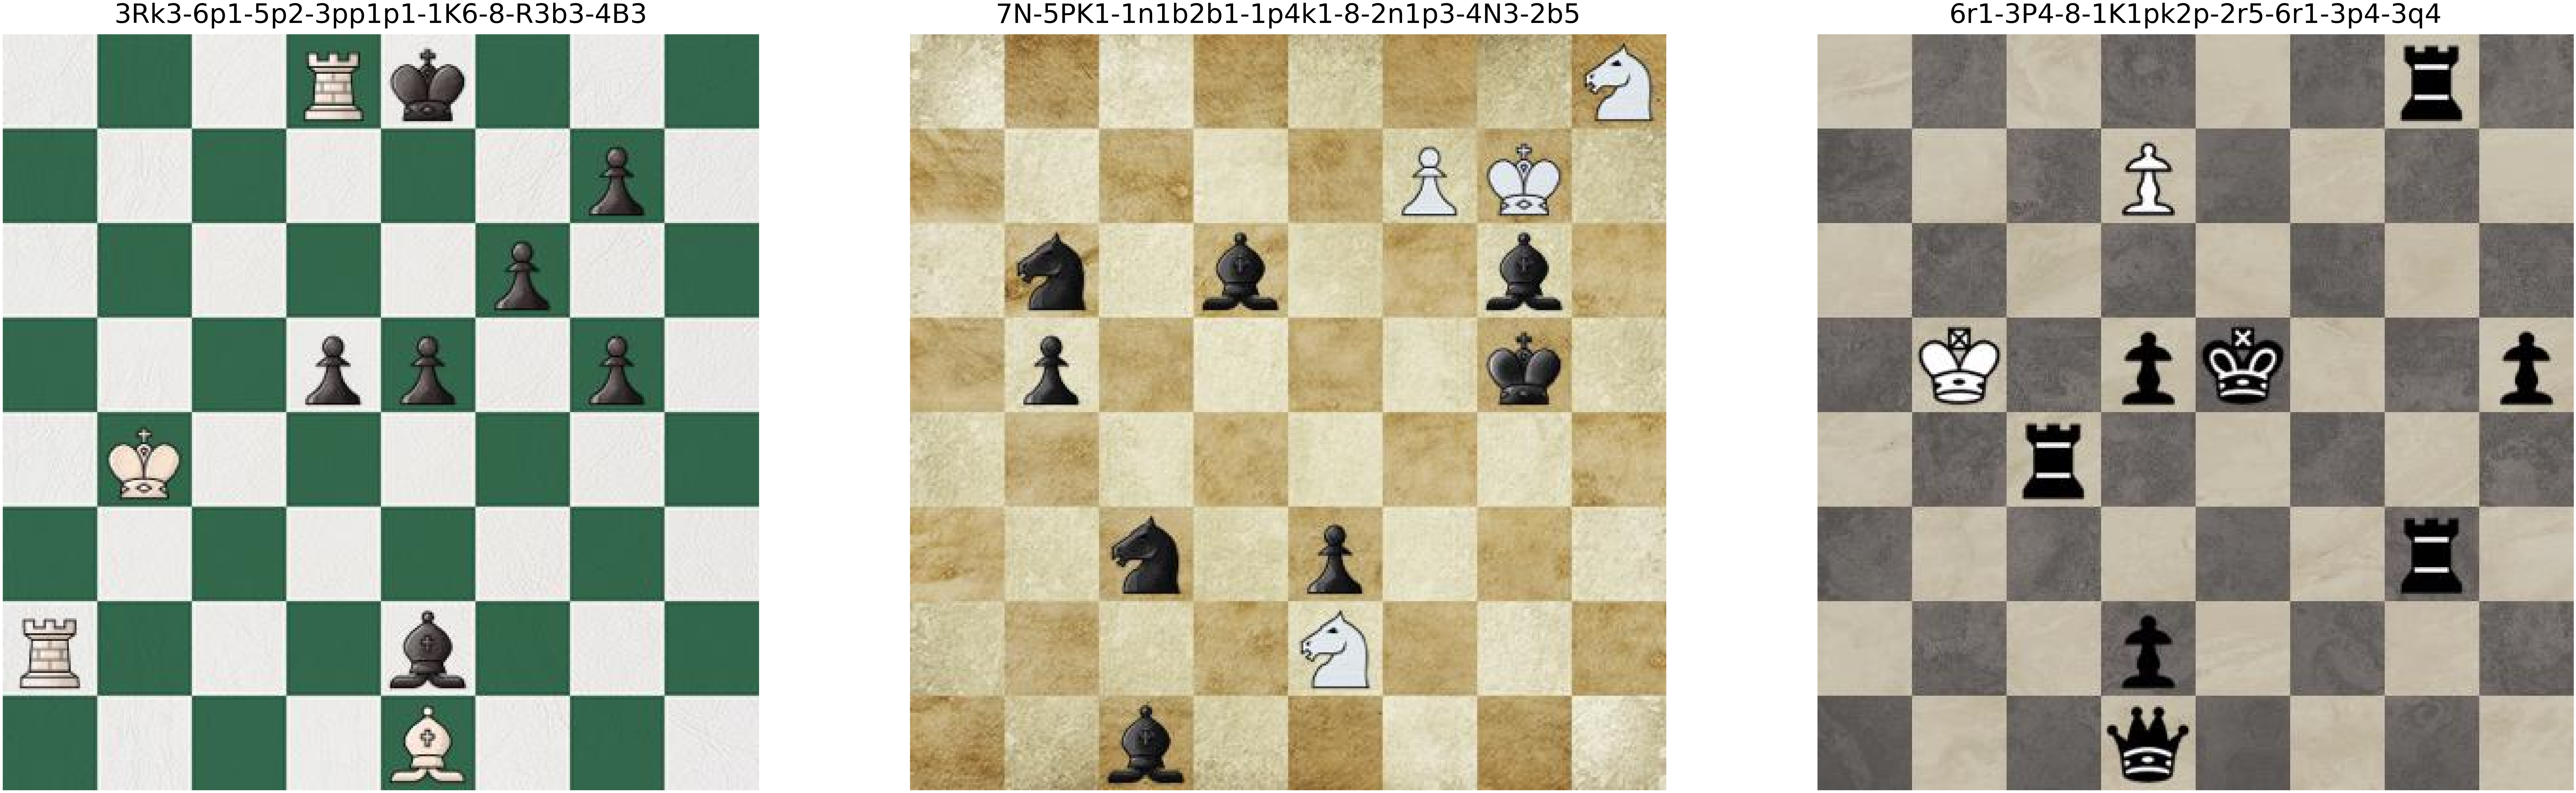

In [110]:
muestra_rango_de_imagenes(train, range(0,3))

# Funciones para tratar las cadenas FEN como one-hot y viceversa.

In [111]:
import numpy as np
import re

def onehot_from_fen(fen):
    """
    Convierte una cadena FEN en una matriz one-hot que representa el estado del tablero de ajedrez.

    Parámetros:
    - fen (str): Cadena FEN que describe la disposición de las piezas en un tablero de ajedrez.

    Retorna:
    - np.ndarray: Una matriz one-hot donde cada fila representa una pieza en el tablero y cada columna
                  representa un tipo de pieza o un espacio vacío.

    Detalles:
    - '12345678' se utilizan para representar el número de espacios vacíos consecutivos.
    - 'piece_symbols' debe ser una lista previamente definida con los símbolos de las piezas correspondientes.
    """
    piece_symbols = 'prbnkqPRBNKQ'
    eye = np.eye(13)  # Crea una matriz identidad para representar las piezas y espacios vacíos.
    output = np.empty((0, 13))  # Inicializa la matriz de salida.
    fen = re.sub('[-]', '', fen)  # Elimina guiones, que no son necesarios en la representación.

    for char in fen:
        if char in '12345678':
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)  # Espacios vacíos.
        else:
            idx = piece_symbols.index(char)  # Encuentra el índice de la pieza en la lista.
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)  # Añade la pieza a la matriz.

    return output

def fen_from_onehot(one_hot):
    """
    Convierte una matriz one-hot en una cadena FEN que representa el estado del tablero de ajedrez.

    Parámetros:
    - one_hot (np.ndarray): Matriz one-hot donde cada fila representa una pieza en el tablero y cada columna
                            representa un tipo de pieza o un espacio vacío.

    Retorna:
    - str: Una cadena FEN que describe la disposición de las piezas en un tablero de ajedrez.

    Detalles:
    - 'piece_symbols' debe ser una lista previamente definida con los símbolos de las piezas correspondientes.
    """
    piece_symbols = 'prbnkqPRBNKQ'
    output = ''
    for j in range(8):
        for i in range(8):
            if one_hot[j][i] == 12:
                output += ' '  # Representa un espacio vacío.
            else:
                output += piece_symbols[one_hot[j][i]]  # Añade el símbolo de la pieza.
        if j != 7:
            output += '-'  # Añade un guión entre las filas.

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))  # Compacta espacios vacíos en números.

    return output


In [135]:
# Ejemplo de onehot from fen limitado a 10 filas
fen = '1r6-8-8-5Q2-1K4r1-6P1-Pb6-3k4'
one_hot = onehot_from_fen(fen)
# Recordar que el orden es: prbnkqPRBNKQ
# La primera fila dice 1 vacia, luego rook, luego 6 vacias. 
# Esto está representado en one-hot de la siguiente manera
# Primera fila, la ultima columna representa casilla vacía y está en 1
# La fila 2, la columna 2, es la rook negra y está en 1
# Luego 6 filas que también representan casilla vacía
print(f"FEN: {fen}")
print(f"One HOT from fen (shape): {one_hot.shape}")
print(f"Visualización de primer fila (1r6):\n{one_hot[0:8]}")

FEN: 1r6-8-8-5Q2-1K4r1-6P1-Pb6-3k4
One HOT from fen (shape): (64, 13)
Visualización de primer fila (1r6):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Función para procesar imágenes de tableros de ajedrez, que regresa los 64 cuadros

In [113]:
from skimage import io, transform
from skimage.util import view_as_blocks

def process_image(img):
    """
    Procesa una imagen reduciéndola a un tamaño especificado y dividiéndola en cuadrados más pequeños.

    Parámetros:
    - img (str): Ruta al archivo de imagen que se va a procesar.

    Retorna:
    - np.ndarray: Un arreglo numpy que contiene 64 tiles (cuadrados) de la imagen, cada uno con
                  dimensiones (SQUARE_SIZE, SQUARE_SIZE, 3), donde 3 representa los canales de color RGB.

    Detalles:
    - 'SQUARE_SIZE' debe ser definida externamente y representa el tamaño de cada cuadrado en el que se divide la imagen.
    - La imagen es redimensionada a un tamaño de (SQUARE_SIZE*8, SQUARE_SIZE*8) antes de ser dividida.
    - Esta función es útil para preparar imágenes para su análisis o procesamiento en tareas que requieren
      datos en forma de cuadrícula o matriz, como el análisis de tableros de juegos.
    """
    new_image_size = SQUARE_SIZE * 8  # Calcula el nuevo tamaño deseado de la imagen.
    square_size = SQUARE_SIZE  # Tamaño de cada cuadrado en el que se dividirá la imagen.
    img_read = io.imread(img)  # Lee la imagen desde la ruta especificada.
    # Redimensiona la imagen al tamaño deseado.
    img_read = transform.resize(img_read, (new_image_size, new_image_size), mode='constant')
    # Divide la imagen en bloques más pequeños de tamaño (square_size, square_size, 3).
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    # Elimina una dimensión redundante que podría haber sido creada durante el proceso de división.
    tiles = tiles.squeeze(axis=2)
    # Reorganiza las baldosas para que estén en una sola dimensión con las dimensiones requeridas por tile.
    return tiles.reshape(64, square_size, square_size, 3)


## Funciones de Generadores para Entrenamiento y Predicción

### Función `train_gen`

Esta función es un generador que prepara lotes de imágenes y sus correspondientes etiquetas para el proceso de entrenamiento. Acepta tres parámetros:

- `features`: Lista de rutas a las imágenes.

El generador procesa cada imagen, la convierte en un formato adecuado para el modelo, y extrae la etiqueta en formato one-hot utilizando el nombre del archivo.

#### Uso:

```python
for x, y in train_gen(path_to_images, labels, 32):
    model.train(x, y)


In [114]:
def train_gen(features, _, batch_size=None):
    """
    Generador que procesa imágenes y etiquetas para entrenamiento en lotes.

    Parámetros:
    - features (list): Lista de rutas de imágenes.
    - labels (list): Lista de etiquetas correspondientes a las imágenes.
    - batch_size (int): Tamaño del lote de datos a procesar.

    Yields:
    - tuple: Retorna tuplas de (imagen procesada, etiqueta en formato one-hot).
    """
    for _, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))  # Convierte el nombre de archivo en etiqueta one-hot.
        x = process_image(img)  # Procesa la imagen para convertirla en un formato adecuado para el modelo.
        yield x, y

def pred_gen(features, batch_size):
    """
    Generador que procesa imágenes para predicción en lotes.

    Parámetros:
    - features (list): Lista de rutas de imágenes.
    - batch_size (int): Tamaño del lote de datos a procesar.

    Yields:
    - array: Retorna imágenes procesadas, listas para ser utilizadas en predicciones.
    """
    for _, img in enumerate(features):
        yield process_image(img)  # Procesa cada imagen y la retorna para su uso en predicción.


# Definición del modelo

## Descripción del Modelo de Red Neuronal Convolucional

### Arquitectura del Modelo

![alt text](arquitectura.png)

La arquitectura del modelo está diseñada para procesar imágenes mediante una serie de capas que extraen características y aplican regularización para mejorar la generalización:

1. **Capas Conv2D**: 
   - Tres capas convolucionales con 32 filtros de tamaño 3x3 y activación ReLU. Estas capas extraen características visuales básicas como bordes y texturas.

2. **Capas de Dropout**: 
   - Capas que aplican un dropout del 20% después de cada capa convolucional para reducir el riesgo de sobreajuste, ayudando al modelo a generalizar mejor a nuevos datos.

3. **Capa MaxPooling2D**: 
   - Una capa de agrupación máxima con un tamaño de 2x2 que reduce la dimensionalidad de las características, conservando las características más prominentes.

4. **Capa Flatten**: 
   - Esta capa aplana las características multidimensionales en un vector unidimensional, preparándolas para el procesamiento en capas densas.

5. **Capas Dense**: 
   - Una capa densa de 128 neuronas con activación ReLU seguida de una capa de salida con 13 neuronas y activación softmax, que clasifica las imágenes en una de las 13 categorías basadas en las características extraídas.

### Compilación del Modelo

- El modelo utiliza la entropía cruzada categórica ponderada como función de pérdida, con un ajuste dinámico de la tasa de aprendizaje y la métrica de precisión para evaluar el rendimiento.


In [115]:
import numpy as np
from keras import models, layers
from keras.optimizers import Nadam

class ChessFENClassifier:
    """
    Clasificador de imágenes de ajedrez para convertir imágenes cuadradas en cadenas FEN utilizando una red neuronal convolucional.

    Atributos:
    - image_size (int): Tamaño de las imágenes (ancho y alto) que acepta el modelo.

    Métodos:
    - __init__(self, image_size): Constructor de la clase que inicializa el tamaño de la imagen.
    - build_model(self): Construye y compila el modelo de red neuronal.
    """

    def __init__(self, image_size):
        """
        Inicializa el clasificador con el tamaño especificado de las imágenes.

        Parámetros:
        - image_size (int): Tamaño de las imágenes cuadradas.
        """
        self.image_size = image_size
        self.model = self.build_model()

    def build_model(self):
        """
        Construye y compila el modelo de red neuronal utilizando la arquitectura CNN con Keras.

        Retorna:
        - model (keras.Model): Modelo de red neuronal convolucional compilado.
        """
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(self.image_size, self.image_size, 3)))
        model.add(layers.Dropout(0.2))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
        model.add(layers.Dropout(0.2))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(13, activation='softmax', kernel_initializer='lecun_normal'))

        model.compile(
            loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

        return model


# Entrenamiento del modelo

In [116]:
classifier = ChessFENClassifier(SQUARE_SIZE)
model = classifier.model
model

In [117]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

10000/10000 [==============================] - 2403s 240ms/step - loss: 0.0242 - accuracy: 0.9941


In [118]:
model.save('modelo_2024_05_13.h5')  # Guarda el modelo en el archivo HDF5.

# Prueba del funcionamiento del modelo

In [119]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

# Resultados de desempeño

El desempeño es satisfactorio tomando en cuenta que clasifica 64 casillas a la vez. Para mejorar los resultados de este modelo siguientes pasos podrían ser:
- Implementar cross validation y callbacks
- Implementar optimización de hiperparámetros, fue tomado en cuenta, pero algunos errores no pudieron corregirse porque el kernel dejaba de funcionar. 
- Implementar crossentropy con pesos, definir estos por la proporción de clases.

In [133]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy*100))

Final Accuracy: 82.03333%


# Demostración de predicción

In [136]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    print(pred)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

In [137]:
from keras.models import load_model

# Carga el modelo desde el archivo HDF5.
model = load_model('modelo_2024_05_13.h5')

2/2 [==============================] - 0s 16ms/step
[[[12  8 12  2 12 12 12 12]
  [12 12 12 12 12 12 12 12]
  [12 12 12 12 12 12 12 12]
  [12 12  8 12 12 12 12 12]
  [12 12 12  2 12 12 12 12]
  [12  8 12 12  0 12 10 12]
  [12 12 12 12 12 12 12 12]
  [12 12 12 12 12 12  4 12]]]


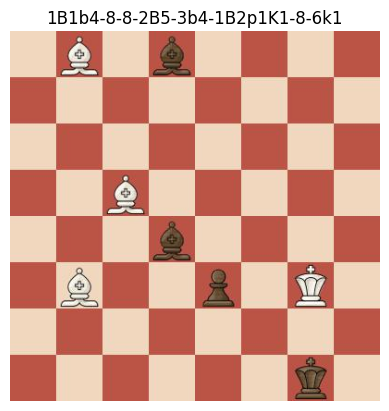

In [138]:
display_with_predicted_fen("./data/test/1B1b4-8-8-2B5-3b4-1B2p1K1-8-6k1.jpeg")